# Quantifying uncertainty in spatial estimates: All about Spatialize's precision module

Usually, we want estimates that are both precise and accurate. ***Accuracy*** indicates how close the predicted values are to the true, unknown values, while ***precision*** indicates the uncertainty associated with the predictions.

Simple spatial interpolators, like K-Nearest Neighbors and Inverse Distance Weighting, lack a method for **quantifying the precision of the estimates**. While the Kriging model can assess precision through the Kriging variance, its correct use requires a lot of expertise.

The implementation of the **Ensemble Spatial Interpolation (ESI)** model within the spatialize library addresses this issue with a flexible, data-driven approach that delivers both *accurate spatial estimates* and *uncertainty quantification*.

## Calculating the Precision of ESI Estimates

**How does the ESI model quantify the uncertainty of its predictions?**

The answer to this question lies in its ensemble approach.

During the ESI procedure, several estimates are generated for each target location using different subsets of the available data. These local estimates are then aggregated to produce the final prediction.

The quantification of uncertainty for a specific location works as follows:
1. Apply a loss function: For each individual estimate, a loss function calculates how much it differs from the final aggregated prediction.
2. Calculate expected loss: The mean of these loss function values provides the uncertainty measure—a  higher value indicates greater disagreement between the local models.

This approach provides a statistically grounded measure of the precision of each spatial estimate.

Mathematically, this is:

For an unmeasured position $x^*$, the final ESI estimation ($\mathbf{\hat{x}}$) is obtained by applying the aggregation function ($G$) to the set of m individual local estimates ($\{\hat{x}_i\}_{i=1}^m$):

$$\mathbf{\hat{x}} = G(\{\hat{x}_i\}_{i=1}^m)$$

Then, a precision model $p^*$ can be defined using a loss function $\mathcal{L}$ as follows:

$$p^* = \frac{1}{m}\sum_{i=1}^{m}\mathcal{L}(\mathbf{\hat{x}}, \hat{x}_i)$$

$\rightarrow$ When using the squared error as loss function, the mean squared error is obtained:

$$p^*_{mse} = \frac{1}{m}\sum_{i=1}^{m}(\mathbf{\hat{x}} - \hat{x}_i)^2$$

$\rightarrow$  When the aggregation function $G$ is the mean (which is the default in spatialize), then $p^*_{mse}$ corresponds to the variance.

> The Spatialize library includes pre-defined loss functions and allows for custom alternatives. This document covers the former.

## Calculating the precision of ESI estimates

In [1]:
# === Libraries ===
import numpy as np

# for ESI estimations
from spatialize.gs.esi import esi_hparams_search, esi_nongriddata

# for ESI precision estimations
import spatialize.gs.esi.lossfunction as lf

# for plots
import matplotlib.pyplot as plt
from spatialize.viz import PlotStyle

# example dataset:
from spatialize.data import load_drill_holes_andes_2D
samples, locations, _, _ = load_drill_holes_andes_2D()


### Preparing the inputs
For this example, we'll use an integrated dataset from the Spatialize library.

We'll define the model inputs from the loaded data:

In [2]:
# Locations of the sample data:
points = samples[['x', 'y']].values

# Values of the sample data:
values = samples[['cu']].values[:, 0]

# Locations to be estimated:
xi = locations[['x', 'y']].values

### Obtaining ESI estimates

Next, we'll use the `esi_hparams_search` function to find optimal parameters for ESI:

In [3]:
search_result = esi_hparams_search(points, values, xi,
                                   local_interpolator="idw",
                                   griddata=False,
                                   k=-1,
                                   p_process="mondrian",
                                   n_partitions=[300],
                                   exponent=[0.1, 0.5, 1, 2, 3, 4],
                                   alpha=(0.7, 0.8, 0.9),
                                   seed=1500)

finished 100% of 18 iterations ... 

done (elapsed time: 30s)


Then, we'll use the `esi_nongriddata` function to produce estimations for all target points:

In [4]:
esi = esi_nongriddata(points, values, xi,
                      local_interpolator="idw",
                      n_partitions=300,
                      best_params_found=search_result.best_result())

est = esi.estimation()

finished 100% of 300 iterations ... 

done (elapsed time:  1m  1s)


The ESI estimates look as follows:

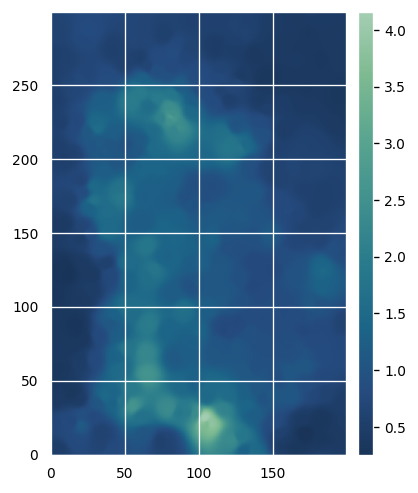

In [5]:
esi.plot_estimation(theme='darkgrid')
plt.show()

### Calculating Precision

The precision() method of the esi_nongriddata output calculates precision for all target points. The default loss function is the Mean Squared Error (MSE).

In [6]:
# Calculate precision
esi.precision()

array([0.00517185, 0.0053864 , 0.00482317, ..., 0.00014108, 0.00017295,
       0.00295822], shape=(60000,))

We'll now visualize the output of all built-in loss calculations in Spatialize. These are the Mean Squared Error (MSE), Mean Absolute Error (MAE), and Operational Error:

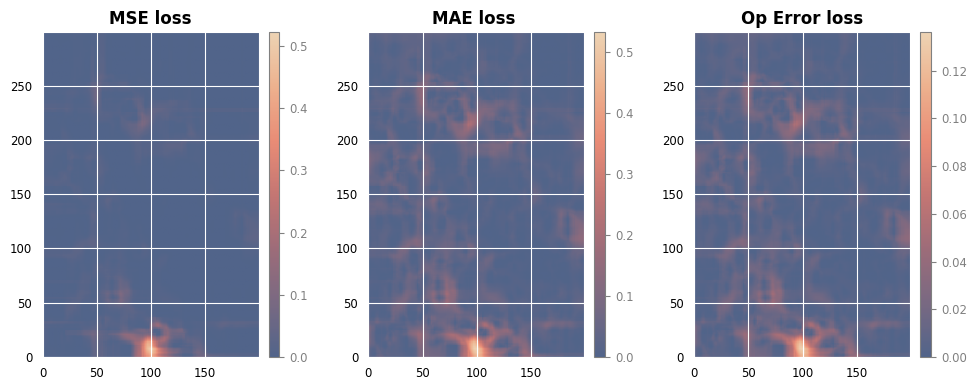

In [7]:
# Visualizing different built-in loss functions

loss_functions = {'MSE loss': lf.mse_loss,
                  'MAE loss ': lf.mae_loss,
                  'Op Error loss': lf.OperationalErrorLoss(values.max()-values.min())
                  }

with PlotStyle(theme = 'darkgrid') as style:
    fig, axs = plt.subplots(1, 3, figsize = (10,4), layout = 'tight')

    for i, (name, function) in enumerate(loss_functions.items()):
        # Calculating and plotting precision
        esi.precision(loss_function=function)
        esi.plot_precision(ax = axs[i], cmap = style.precision_cmap)
        axs[i].set_title(name)
    plt.show()